# Paper Implementation
## END-TO-END TRAINED CNN ENCODER-DECODER NETWORKS FOR IMAGE STEGANOGRAPHY - Atique </i> $et.al$
## Tensorflow 2.0
###  Notebook Author: Saad Zia

In [1]:
import numpy as np
import tensorflow as tf
import pickle

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# For process to not allocate entire GPU memory

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)


#### Setting up Data Pipeline

In [3]:
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
x = x.astype(np.float32)
x_test = x_test.astype(np.float32)

In [5]:
payload_train = np.mean(x, axis=-1)[:100, :, :, np.newaxis]
host_train = x[np.random.choice(np.arange(x.shape[0]), size=payload_train.shape[0])][:100]

payload_test = np.mean(x_test, axis=-1)[:10, :, :, np.newaxis]
host_test = x_test[np.random.choice(np.arange(x_test.shape[0]), size=payload_test.shape[0])][:10]

In [6]:
# Instantiate the Dataset class
train_dataset = tf.data.Dataset.from_tensor_slices((payload_train, host_train))

In [7]:
# Normalization function
def normalize(payload, host):
    payload = tf.image.per_image_standardization(payload)
    host = tf.image.per_image_standardization(host)
    return payload, host

# Adding shuffle, normalization and batching operations to the dataset object
train_dataset = train_dataset.map(normalize).shuffle(100).batch(32, drop_remainder=True)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [8]:
# Instantiate the test Dataset class
test_dataset = tf.data.Dataset.from_tensor_slices((payload_test, host_test))
test_dataset = (test_dataset.map(normalize).batch(10, drop_remainder=True))

#### Setting up tf.keras Model

In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [10]:
tf.keras.backend.set_floatx('float32')
tf.keras.backend.floatx()

'float32'

In [11]:
from encoder import EncoderNetwork
from decoder import DecoderNetwork

In [12]:
encoder_network = EncoderNetwork()
decoder_network = DecoderNetwork()

In [13]:
carrier_image_shape=(32, 32, 3)
payload_image_shape=(32, 32, 1)

input_carrier = Input(shape=carrier_image_shape, name='input_carrier')
input_payload = Input(shape=payload_image_shape, name='input_payload')

In [14]:
encoded_output = encoder_network.get_network(input_carrier, input_payload)
decoded_output = decoder_network.get_network(encoded_output)

In [15]:
steganography_model = Model(inputs=[input_carrier, input_payload], outputs=[encoded_output, decoded_output])

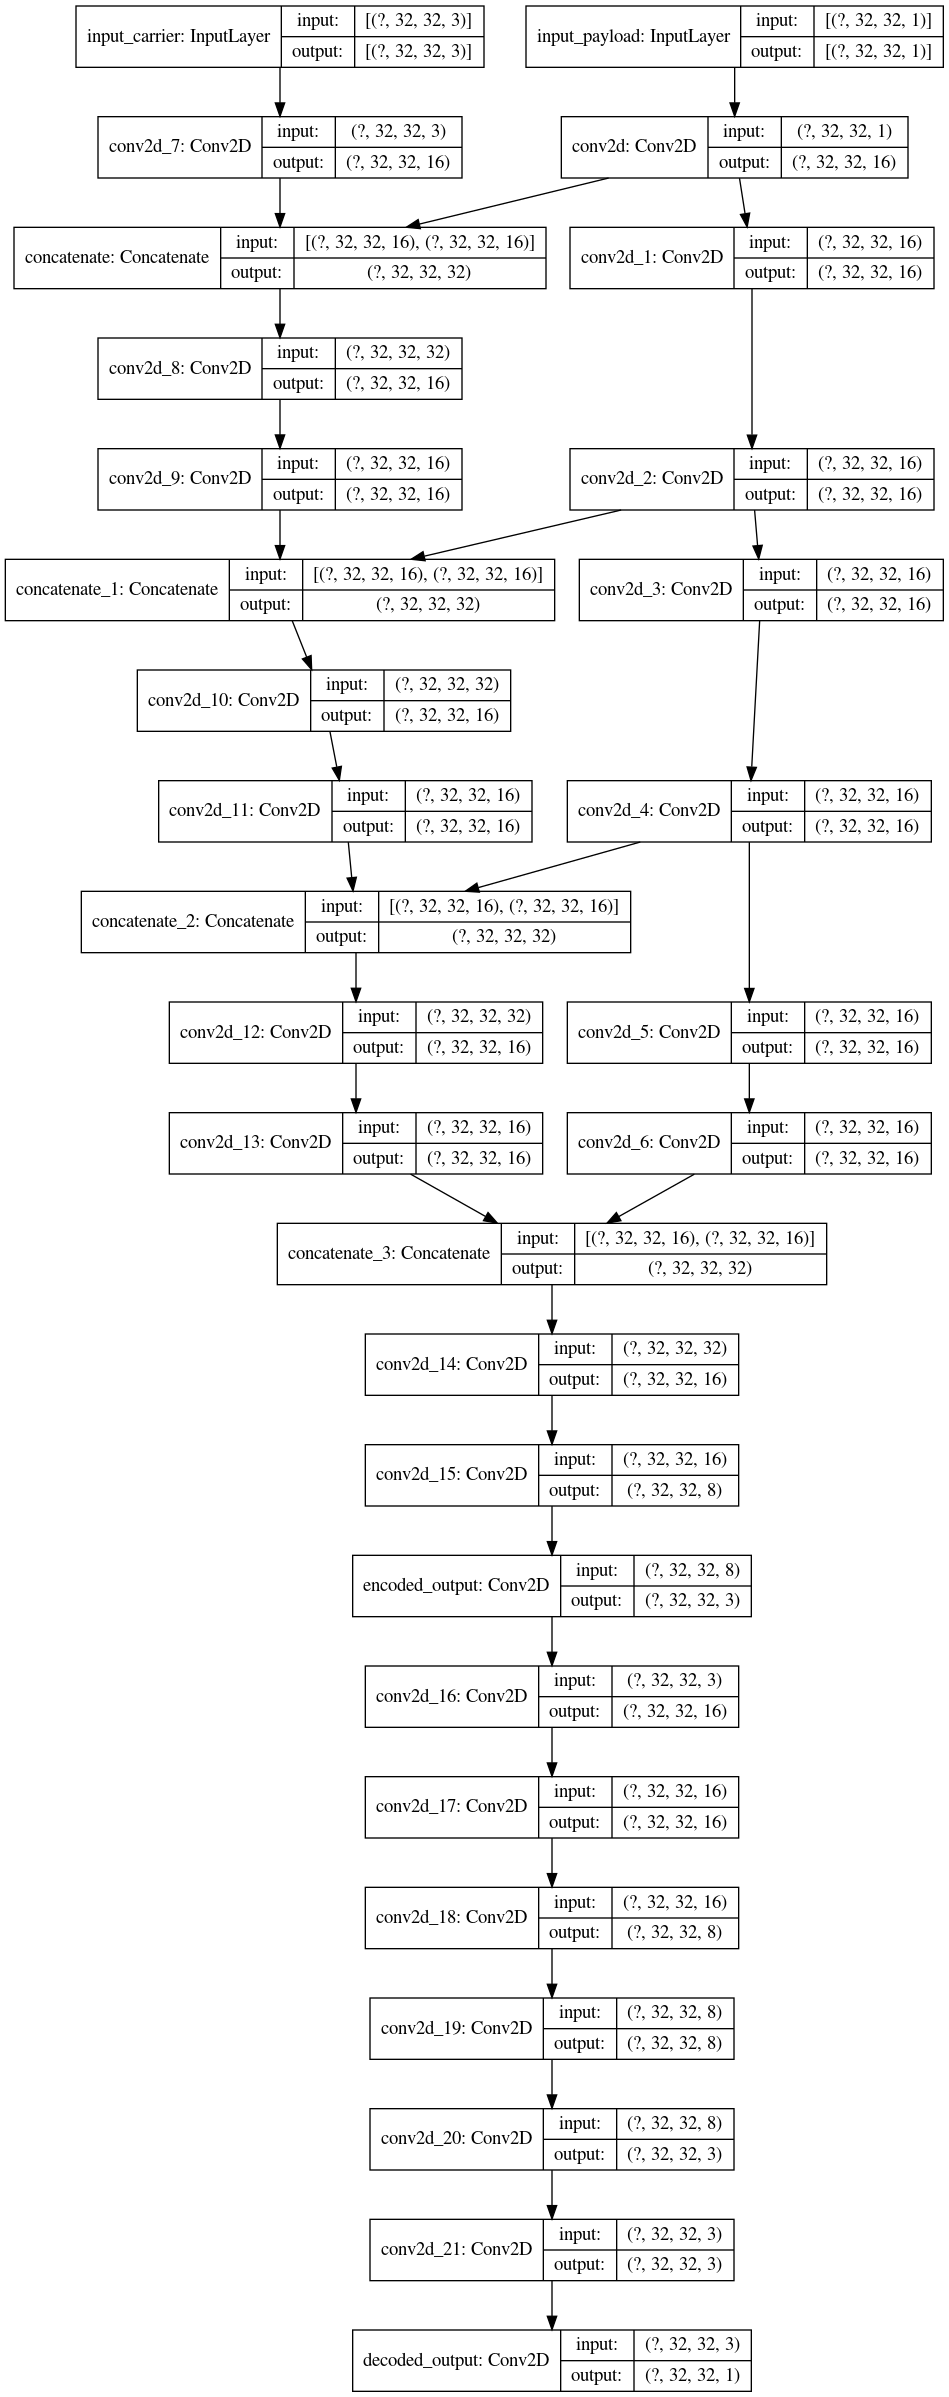

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(steganography_model, show_shapes=True)

In [17]:
steganography_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_carrier (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_payload (InputLayer)      [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 16)   448         input_carrier[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   160         input_payload[0][0]              
______________________________________________________________________________________________

In [18]:
# Defining Loss Function

@tf.function
def loss_function(payload, host, encoder_output, decoder_output):
    
    loss = tf.math.reduce_mean(tf.math.squared_difference(payload, decoder_output)\
                           + tf.math.squared_difference(host, encoder_output))
        
    return loss


In [19]:
def custom_loss(input_):
    def loss(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.squared_difference(y_true, y_pred))
    return loss             

In [23]:
optimizer = tf.keras.optimizers.Adam(0.0001)

In [24]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(payload, host):
    with tf.GradientTape() as tape:
        encoded_host, decoded_payload = steganography_model([host, payload])
        loss = loss_function(payload, host, encoded_host, decoded_payload)
        train_loss(loss)
    gradients = tape.gradient(loss, steganography_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, steganography_model.trainable_variables))



@tf.function
def test_step(payload, host):
    encoded_host, decoded_payload = steganography_model([host, payload])
    t_loss = loss_function(payload, host, encoded_host, decoded_payload)
    test_loss(t_loss)

EPOCHS = 5000
SUMMARY_DIR = './summary'

import time


for epoch in range(EPOCHS):
    start = time.time()
    for payload, host in train_dataset:
        train_step(payload, host)

    for payload, host in test_dataset:
        test_step(payload, host)

    elapsed = time.time() - start
    print('elapsed: %f' % elapsed)

    template = 'Epoch {}, Train Loss: {}, Test Loss: {}'
    print(template.format(epoch+1, train_loss.result(), test_loss.result()))

    # Reset the metrics for the next epoch
    test_loss.reset_states()

print('Training Finished.')

elapsed: 1.454475
Epoch 1, Train Loss: 0.5358107686042786, Test Loss: 0.5404237508773804
elapsed: 0.151105
Epoch 2, Train Loss: 0.5368791222572327, Test Loss: 0.5406345129013062
elapsed: 0.183046
Epoch 3, Train Loss: 0.5349658131599426, Test Loss: 0.5415666103363037
elapsed: 0.171731
Epoch 4, Train Loss: 0.5345349311828613, Test Loss: 0.5409784913063049
elapsed: 0.180917
Epoch 5, Train Loss: 0.5337894558906555, Test Loss: 0.5407440066337585
elapsed: 0.169868
Epoch 6, Train Loss: 0.5336931943893433, Test Loss: 0.5405589938163757
elapsed: 0.168953
Epoch 7, Train Loss: 0.5334850549697876, Test Loss: 0.5407078266143799
elapsed: 0.158590
Epoch 8, Train Loss: 0.5329857468605042, Test Loss: 0.5403977632522583
elapsed: 0.215309
Epoch 9, Train Loss: 0.5329174399375916, Test Loss: 0.5405903458595276
elapsed: 0.203189
Epoch 10, Train Loss: 0.5325341820716858, Test Loss: 0.5408440232276917
elapsed: 0.245572
Epoch 11, Train Loss: 0.5328629016876221, Test Loss: 0.5404842495918274
elapsed: 0.183421
E

KeyboardInterrupt: 

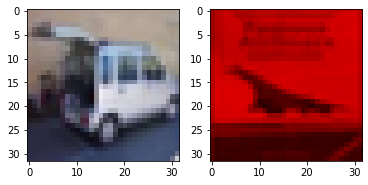

In [59]:
example_ids = [0, 1, 2, 3]
example_id = np.random.choice(example_ids)

# showing host 
fig, axs = plt.subplots(ncols=2)

host_example = host_test.astype(int)[example_id]
payload_example = payload_test.astype(int)[example_id]
payload_example = np.concatenate((payload_example, np.zeros_like(payload_example), np.zeros_like(payload_example)), axis=-1)
axs[0].imshow(host_example)
axs[1].imshow(payload_example)

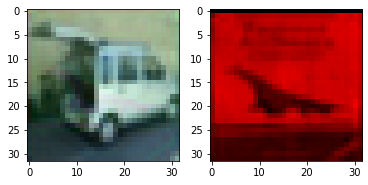

In [60]:
# showing host 
fig, axs = plt.subplots(ncols=2)

inference_dataset = tf.data.Dataset.from_tensor_slices((host_test[example_ids], payload_test[example_ids])).batch(len(example_ids))
for host, payload in inference_dataset:
    encoded_host, decoded_payload = steganography_model([host, payload])
    host_outputs = encoded_host.numpy()
    payload_output = decoded_payload.numpy()

host_output = host_outputs.astype(int)[example_id]
payload_output = payload_output.astype(int)[example_id]

    
payload_output = np.concatenate((payload_output, np.zeros_like(payload_output), np.zeros_like(payload_output)), axis=-1)
axs[0].imshow(host_output)
axs[1].imshow(payload_output)